In [5]:
import os
import sys
import numpy as np
import json


sys.path.append('..')
from configs.arguments import get_config_dict
from utils.multiview_utils import Camera, Calibration, MultiviewVids
# from utils.io_utils import write_json, load_json
# from utils.metadata_utils import get_cam_names
# from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
# from utils.plot_utils import rotation_matrix, perp

from scipy.spatial.transform import Rotation as R
from skspatial.objects import Point, Vector, Plane, Points, Line
# import pyransac3d as pyrsc

# import copy
# import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib widget

arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')

# load arguments from the arg parser
config = get_config_dict()
# data_root = config["main"]["data_root"]
# calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
# video_dir = os.path.join(data_root, 'raw_data', 'footage')
# reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
# omni_tag = '360'


# reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
# if not os.path.exists(reconstruction_dir):
#     print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    

In [2]:
mvvids = MultiviewVids(newest=False, config=config)

max_frame = np.min([10, mvvids.get_max_frame_id() - 1])
step = 2
base_frames = {}

frame_ids = list(np.arange(0, max_frame, step))

base_frames = mvvids.extract_mv(frame_ids, undistort = True)

16:24:17.567 - [...bration/../utils/multiview_utils.py:867] - INFO     - Cameras: ['cam1', 'cam2', 'cam3', 'cam4']
16:24:17.620 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam1'
16:24:17.669 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam2'
16:24:17.716 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam3'
16:24:17.736 - [...bration/../utils/multiview_utils.py:269] - WARNING  - Discarding frame IDs {0} that are out of range.
16:24:17.737 - [...bration/../utils/multiview_utils.py:655] - WARNING  - Unable to read JSON /mnt/f/Github/MARMOT/data/0-calibration/calibs/cam4.json, initialising with default values
16:24:17.738 - [...bration/../utils/multiview_utils.py:657] - WARNING  - list index out of range


Dropdown(description='Camera:', options=('cam1', 'cam2', 'cam3'), value='cam1')

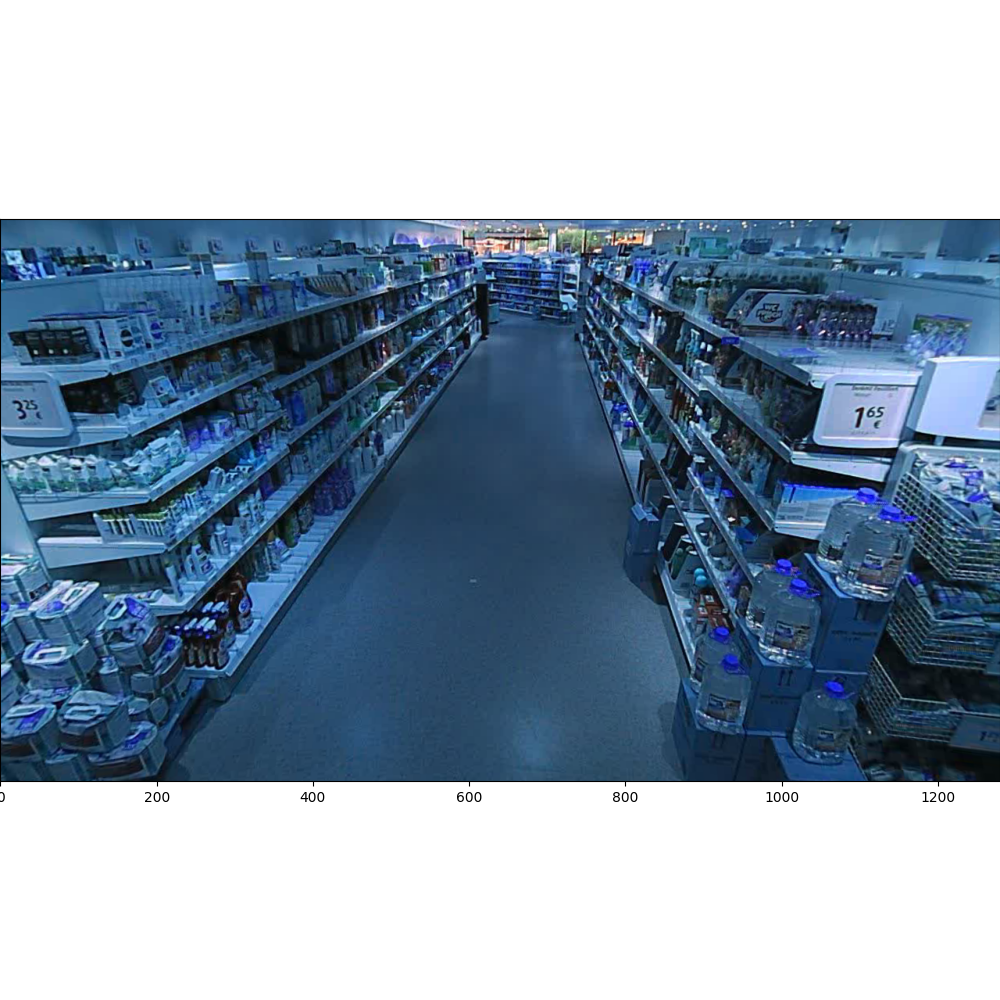

In [3]:
plt.close('all')

from matplotlib.patches import Polygon


roi_points = {cam.name: [] for cam in mvvids.cams}

# create dropdown widget with camera names as options
cam_dropdown = widgets.Dropdown(
    options=[cam.name for cam in mvvids.cams],
    value=mvvids.cams[0].name,
    description='Camera:',
    disabled=False,
)

def onclick(event, cam):
    ax.plot(event.xdata, event.ydata, 'rx', markersize=10)
    roi_points[cam.name].append(([event.xdata, event.ydata]))

    # check if we have at least 3 points to define a polygon
    if len(roi_points[cam.name]) >= 3:
        # get the x and y coordinates of the clicked points
        x, y = zip(*roi_points[cam.name])

        # create a polygon patch with the clicked points
        polygon = Polygon(list(zip(x, y)), alpha=0.2, facecolor='C0')

        # remove any existing polygon patches from the axes
        for patch in ax.patches:
            patch.remove()

        # add the new polygon patch to the axes
        ax.add_patch(polygon)

    fig.canvas.draw()
    pass

def update_cam(change):
    ax.cla()
    global cam
    cam_name = change.new
    cam = next(cam for cam in mvvids.cams if cam.name == cam_name)
    ax.set_title(f"Camera: {cam.name}")
    ax.imshow(base_frames[cam.name][0])
    fig.canvas.draw()
    pass

cam_dropdown.observe(update_cam, names='value')

cam = mvvids.cams[0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(base_frames[cam.name][0])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, cam))

display(cam_dropdown)
# display(fig)

# Save Calibs

In [4]:
print(roi_points)

# Save updated calibrations
for camera in mvvids.cams:
    print(f"Saving calibration data for camera: {camera.name}")
    camera.set_calib(Calibration(ROI = roi_points[camera.name]))
    camera.save_calibration()

{'cam1': [[612.87599609375, 147.275625], [226.31599609375002, 689.995625], [893.1959960937501, 710.475625], [730.63599609375, 154.95562499999994]], 'cam2': [[329.99599609375, 273.995625], [423.43599609375, 711.755625], [1026.31599609375, 688.715625], [452.87599609375, 259.915625]], 'cam3': [[374.79599609375003, 250.95562499999994], [596.23599609375, 696.395625], [1272.07599609375, 536.395625], [486.15599609375, 231.755625]]}
Saving calibration data for camera: cam1
Saving calibration data for camera: cam2
Saving calibration data for camera: cam3
